**IMPORTING LIBRARIES**

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

In [29]:
def rgb_gray(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray_img

**LOAD DATA**

In [30]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [31]:
print(x_train.shape)
print(x_test.shape)
img_dim = x_train.shape[1]
channels = 3

(50000, 32, 32, 3)
(10000, 32, 32, 3)


CONVERT RGB TRAINING IMAGES TO GRAYSCALE IMAGES

In [32]:
x_train_Gray = []
x_test_Gray = []


for i in range(x_train.shape[0]):
  img = x_train[i]
  x_train_Gray.append(rgb_gray(img))

for i in range(x_test.shape[0]):
  img = x_test[i]
  x_test_Gray.append(rgb_gray(img))


In [33]:
print(len(x_train_Gray))
print(len(x_test_Gray))

50000
10000


In [34]:
x_train_Gray = np.asarray(x_train_Gray)
x_test_Gray = np.asarray(x_test_Gray)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_Gray = x_train_Gray.astype('float32')/255
x_test_Gray = x_test_Gray.astype('float32')/255


In [35]:
x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, channels)
x_test = x_test.reshape(x_test.shape[0], img_dim, img_dim, channels)
x_train_Gray = x_train_Gray.reshape(x_train_Gray.shape[0], img_dim, img_dim, 1)
x_test_Gray = x_test_Gray.reshape(x_test_Gray.shape[0], img_dim, img_dim, 1)

In [36]:
input_shape = (img_dim, img_dim, 1)
lat_dim = 256

**ENCODER MODEL**

In [37]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)

In [38]:
shape = tf.keras.backend.int_shape(x)

In [39]:
x = Flatten()(x)
latent = Dense(lat_dim, name='latent_vector')(x)

In [40]:
encoder = Model(inputs, latent, name='encoder_model')

In [41]:
encoder.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 256)                 │       1,048,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,418,496 (5.41 MB)

 Trainable params: 1,418,496 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

**DECODER MODEL**

In [42]:
latent_inputs = Input(shape = (lat_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [43]:
x = Conv2DTranspose(256, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

In [44]:
outputs = Conv2DTranspose(3, (3,3), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)

In [45]:
decoder = Model(latent_inputs, outputs, name = 'decoder_model')

In [46]:
decoder.summary()

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2DTranspose)     │ (None, 32, 32, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,013,315 (7.68 MB)

 Trainable params: 2,013,315 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

**AUTOENCODER MODEL**

In [47]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')

In [48]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_model (Functional)           │ (None, 256)                 │       1,418,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_model (Functional)           │ (None, 32, 32, 3)           │       2,013,315 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,431,811 (13.09 MB)

 Trainable params: 3,431,811 (13.09 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 5, verbose = 1, min_lr = 0.5e-6)

In [50]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [51]:
print(filepath)

/content/saved_models/colorized_ae_model.h5


In [53]:
filepath = '/content/saved_models/colorized_ae_model.keras'
checkpoints = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [54]:
callbacks = [lr_reducer, checkpoints]

**TRAINING**

In [55]:
autoencoder.compile(loss = 'mse', optimizer = 'Adam', metrics = ['accuracy'])

In [56]:
autoencoder.fit(x_train_Gray, x_train, validation_data = (x_test_Gray, x_test),epochs = 30, batch_size = 32, callbacks = callbacks)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4740 - loss: 0.0227
Epoch 1: val_loss improved from inf to 0.01071, saving model to /content/saved_models/colorized_ae_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.4740 - loss: 0.0227 - val_accuracy: 0.5089 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 2/30
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5024 - loss: 0.0103
Epoch 2: val_loss improved from 0.01071 to 0.00931, saving model to /content/saved_models/colorized_ae_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.5024 - loss: 0.0103 - val_accuracy: 0.5190 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 3/30
1557/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5129 - loss: 0.0090
Epoch 3: val_loss improved from 0.00931 to 0.00868, saving model to /content/saved_models/colorized_ae_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5129 - loss: 0.0090 - val_accuracy: 0.5006 - val

In [57]:
x_decoded = autoencoder.predict(x_test_Gray)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [58]:
autoencoder.save('colourization_model.h5')

In [59]:
from google.colab import files
files.download('colourization_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Displaying Results**

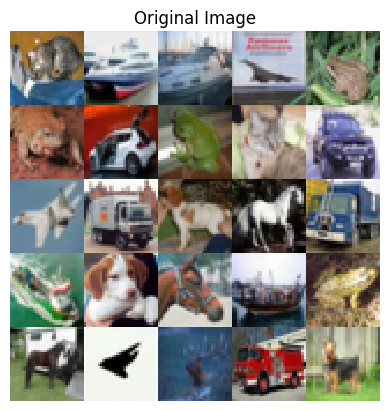

In [60]:
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Original Image')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

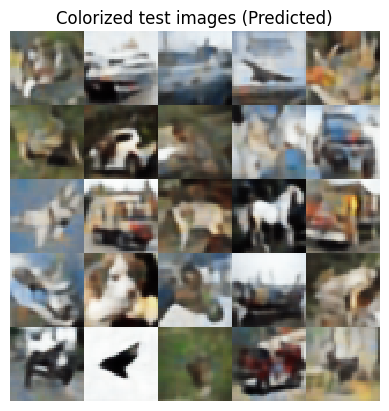

In [61]:
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
#plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()